### Installing packages

In [ ]:
# %% capture
# #Installing libraries
# !pip install python-calamine geopandas

### Loading packages

In [1]:
# Importing libraries

# DS libraries
import pandas as pd
from python_calamine.pandas import pandas_monkeypatch
import numpy as np
import os
import getpass
import re # for regular expresion

# GIS libraries
import geopandas as gpd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Assign paths

In [2]:
# Set Paths 
user=getpass.getuser() # Get user
if user == 'sebas':
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"
else:
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"

# Handle covariates


## 01 - IDEAM information

In this part of the code I handle precipitation information provided by Institute of Hydrology, 
Meteorology and Environmental Studies (IDEAM), Colombian official environment
institution in order to get a time-series by every sensor (panel dataset).

### Section needs
Inputs:

* precip_path: "RawData/Respuesta Solicitud_Ideam/"
* sensores_path: "PrecipitacionNacionalDiaria/"
* master_shzone: "CreatedData/Temporary/munisXsubhidrozones.csv"
* munis_path: "RawData/MUNICIPIOS_GEODANE/"
* munis_name: "MGN_MPIO_POLITICO.shp"

In [3]:
# Set paths
# Set Paths.
user = getpass.getuser() # Get user.
if user == 'sebas':
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"
else:
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"
    
ideam_info='RawData/Respuesta Solicitud_Ideam/'
sensores_path='PrecipitacionNacionalDiaria/'
munis_path = "RawData/MUNICIPIOS_GEODANE/MGN_MPIO_POLITICO.shp"
output_path = "CreatedData/Temporary/"

In [11]:
# Loading Sensors directory with coordinates.
pandas_monkeypatch()
CNE_ideam=pd.ExcelFile(mainpath+ideam_info+"CNE_IDEAM.xls",engine='calamine')
#print(CNE_ideam.sheet_names)
CNE_ideam=CNE_ideam.parse()
#CNE_ideam.columns
CNE_ideam=CNE_ideam[['CODIGO','nombre','CATEGORIA','TECNOLOGIA','FECHA_INSTALACION', 'altitud','latitud',
                   'longitud','AREA_HIDROGRAFICA','ZONA_HIDROGRAFICA','FECHA_SUSPENSION','SUBZONA_HIDROGRAFICA']]

# Listing sensor information files
files=os.listdir(mainpath+ideam_info+sensores_path)

# Empty DF to store Sensorst information.
ideam_TS=pd.DataFrame()
# Looping over every senros information avaible 
for f in files:
    temp=pd.read_csv(mainpath+ideam_info+sensores_path+f,sep='|') # Load data
    temp['Fecha']=pd.to_datetime(temp['Fecha']) # To datetime format
    temp['year']=temp['Fecha'].dt.year # Extracting year
    temp=temp[temp['year']>=1970] # Filtering by relevant sensors information
    temp=temp.groupby('year').agg(tot_ppm_year=('Valor','sum')).reset_index() # Aggrupating by year
    temp['sensor']=re.findall(pattern='[0-9]{1,}',string=f)[0] # Asign sensor number
    temp['sensor']=temp['sensor'].astype('int64') # String to interger
    temp=temp.merge(CNE_ideam,left_on='sensor',right_on='CODIGO') # merging data
    ideam_TS=pd.concat([ideam_TS,temp])
    del temp
ideam_TS=ideam_TS[['year', 'tot_ppm_year', 'sensor', 'CODIGO', 'nombre','FECHA_INSTALACION', 'latitud', 'longitud',
                   'AREA_HIDROGRAFICA', 'ZONA_HIDROGRAFICA','SUBZONA_HIDROGRAFICA','FECHA_SUSPENSION']]
ideam_TS_15_22=ideam_TS[(ideam_TS['year']>=2015) & (ideam_TS['year']<=2022)]
print(f'Total sensors: {len(ideam_TS['sensor'].unique())}/4453 active since 1970')
print(f'Total sensors: {len(ideam_TS_15_22['sensor'].unique())}/4423 active since 2015')


Total sensors: 2681/4453 active since 1970
Total sensors: 1709/4423 active since 2015


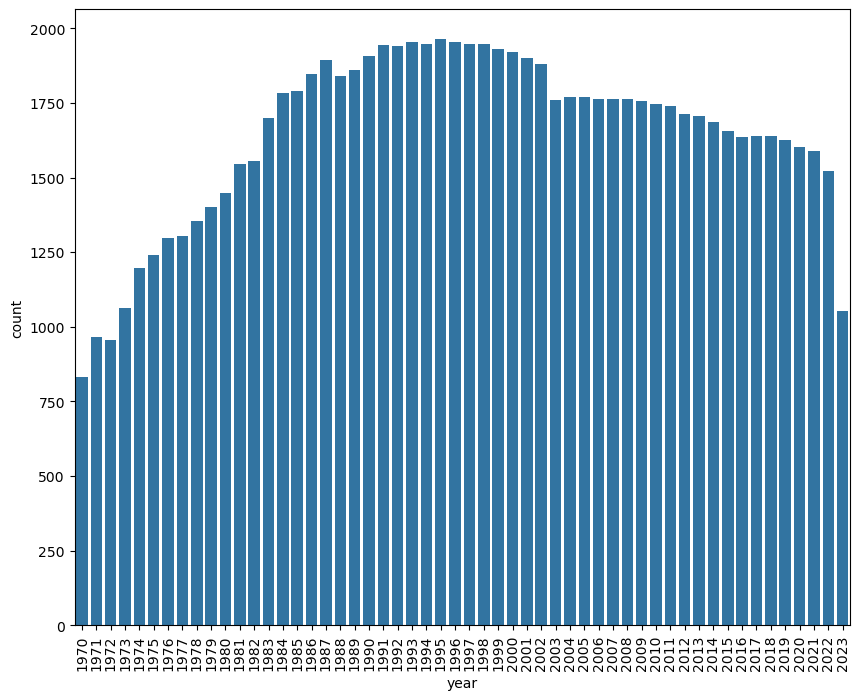

In [ ]:
# Plot of number of active sensors by yead
plt.figure(figsize=(10,8))
sns.countplot(data=ideam_TS,x='year')
plt.xticks(rotation=90)
plt.show()

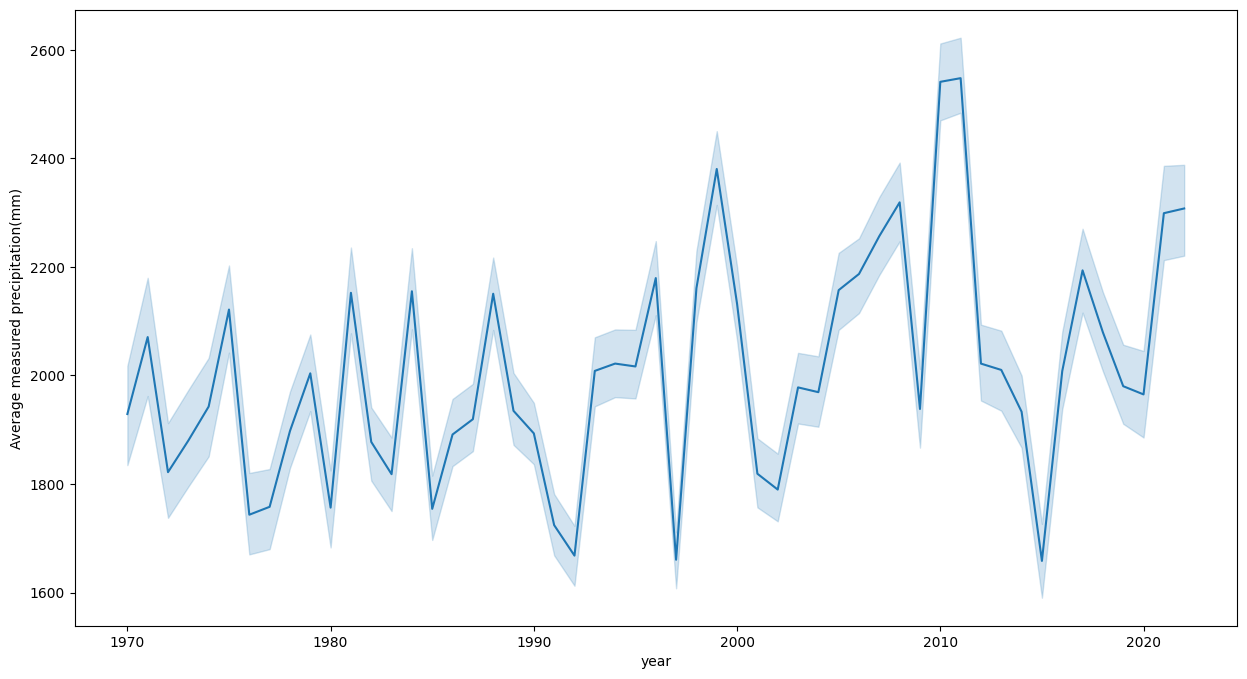

In [ ]:
# Plot of number of active sensors by yead
plt.figure(figsize = (15, 8)) # figsize = (15, 8)
sns.lineplot(data = ideam_TS[ideam_TS.year < 2023], x = 'year', y = 'tot_ppm_year', errorbar = ('ci'))
#plt.xticks(rotation = 90)
plt.ylabel('Average measured precipitation(mm)')
# Save the plot as a PNG file
plt.savefig(mainpath+'Paper/Figures/precipitation_lineplot.png')

plt.show()

# 02 - Hydrologic zones information

In this code I handle hydrographic zones information in order to identify the share of influence of those zones in the municipality. This information comes from hydrographic zonification made by the Colombian's authority the National Institute of Geographic Agustin Codazzi (IGAC).

For that, I filter and plot active sensors in my period of interest (2015-2022) and indentify wich municipalities has not sensors information. In order to solve that missing information, I triangulate the 3 nearest sentos to each municipality without any sensor information

## Code needs
Inputs:

* Hydro zone path: "RawData/Zonificacion_Hidrografica_2013/SHAPE/"  
* Hydro zones shapefile: "Zonificacion_hidrografica_2013.shp" 
* Municipalities path: "RawData/MUNICIPIOS_GEODANE/" 
* Municipalities shapefile: "MGN_MPIO_POLITICO.shp"


In [12]:
# Set paths
hydro_zone_path = "RawData/Zonificacion_Hidrografica_2013/SHAPE/Zonificacion_hidrografica_2013.shp"  
muni_path = "RawData/MUNICIPIOS_GEODANE/MGN_MPIO_POLITICO.shp"
sensors_sp = "CreatedData/Temporary/IDEAM_sensors_coor/" 

### Sensors coordinates

In [13]:
# Sensors coordinates
CNE_ideam_sp=gpd.GeoDataFrame(CNE_ideam,
                              geometry=gpd.points_from_xy(CNE_ideam['longitud'],CNE_ideam['latitud']),
                              crs="EPSG:4326").to_crs(9377)

CNE_ideam_sp['year_suspension']=CNE_ideam_sp['FECHA_SUSPENSION'].dt.year
CNE_ideam_sp['year_suspension']=np.where(CNE_ideam_sp['year_suspension']==2103,2013,CNE_ideam_sp['year_suspension'])
CNE_ideam_sp.shape

# Filtering for sensors with no suspension date or suspension date after 2015.
CNE_ideam_sp_fil = CNE_ideam_sp[(CNE_ideam_sp['CODIGO'].isin(ideam_TS_15_22['CODIGO']))]
print(CNE_ideam_sp_fil.shape)


# Loading Municipalities.
muni_sp = gpd.read_file(mainpath+munis_path).to_crs('EPSG:9377') # Load and tranform crs
# muni_sp.columns
# muni_sp.head()
muni_sp = muni_sp[['MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR','geometry']].\
        rename(columns={'MPIO_CDPMP':'codmpio', 'DPTO_CNMBR':'depname', 'MPIO_CNMBR':'muniname'})
muni_sp['codmpio'] = muni_sp['codmpio'].astype('int64')
muni_sp['total_area'] = muni_sp['geometry'].area

(1709, 14)


<Figure size 640x480 with 0 Axes>

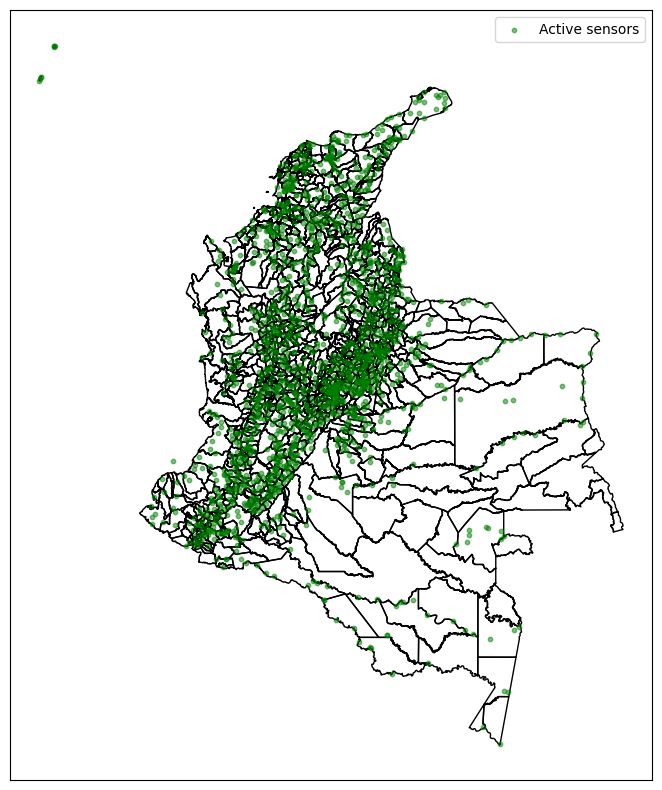

In [17]:
plt.figure()
ax = muni_sp.plot(facecolor = 'none', edgecolor = 'black',figsize = (10, 10))
CNE_ideam_sp_fil.plot(ax = ax, alpha = 0.5, markersize = 10, 
                      color = 'green', label = 'Active sensors')
# CNE_ideam_sp.plot(ax = ax, markersize = 5, color = 'red', 
#                   alpha = 1, label = 'Unactive sensors')

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend() # Add legend

# Save the plot as a PNG file
plt.savefig(mainpath+'Paper/Figures/IDEAM_sensors_py.png')

plt.show() # Display plot

<Figure size 640x480 with 0 Axes>

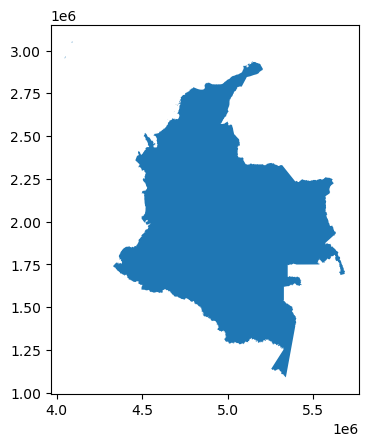

In [24]:
# Creating Colombia's shapefile
colombia_sp = muni_sp.union_all()
colombia_gdf=gpd.GeoDataFrame(data={'pais':['Colombia'],'geometry':colombia_sp},crs=9377)
colombia_gdf.to_file(mainpath+'CreatedData/Temporary/Colombia/Colombia.shp')
# Ploting Colomba shp
plt.figure()
colombia_gdf.plot()
plt.show()

### Loading subhydrographic subzones

In [14]:

hydro_subzone=gpd.read_file(mainpath+hydro_zone_path).to_crs('EPSG:9377')
# print(hydro_subzone.columns)
# hydro_subzone.head()
hydro_subzone=hydro_subzone[['COD_AH','COD_ZH','COD_SZH','NOM_AH','NOM_ZH','NOM_SZH','geometry']]
# duplicates_subzone=hydro_subzone.duplicated(subset=['COD_SZH'],keep=False)
# hydro_subzone[duplicates_subzone]
# hydro_subzone[duplicates_subzone].plot(alpha=0.5)

# Searching on IDEAM map
# https://www.arcgis.com/home/webmap/viewer.html?webmap=103b63dcc9f448acbd63f22b728b1a02#!
# The 5309 has wrong shape, needed to merge his two geometryes, the drop the other duplicabe caused by ovelap geometry
hydro_subzone.loc[hydro_subzone['COD_SZH']==5309,'geometry']=hydro_subzone['geometry'].iloc[313].union(hydro_subzone['geometry'].iloc[315])
hydro_subzone=hydro_subzone.drop_duplicates(subset=['COD_SZH'],keep='first')

### Overlap Municipalities with subhydrographic zones

In [15]:
# Performing municipalities divition
muni_hydro_subzone=gpd.overlay(muni_sp,hydro_subzone,how='intersection')
muni_hydro_subzone['subhydro_area_in_muni']=muni_hydro_subzone.geometry.area
muni_hydro_subzone['sz_area_km2']=muni_hydro_subzone['total_area']*0.000001
muni_hydro_subzone['subhydro_area_in_muni_km2']=muni_hydro_subzone['subhydro_area_in_muni']*0.000001

# GeoDataFrame intersection with Sensors coordinates.
muni_hydro_subzone_sensors=muni_hydro_subzone.sjoin(CNE_ideam_sp_fil[['CODIGO','geometry']],how='left')
muni_hydro_subzone_sensors.drop(columns=['index_right'],inplace=True)
muni_hydro_subzone_sensors=muni_hydro_subzone_sensors.drop_duplicates()
# print(muni_hydro_subzone_sensors.info()) # 4450/6291 non-null
muni_hydro_subzone_sensors_nan=muni_hydro_subzone_sensors[muni_hydro_subzone_sensors['CODIGO'].isna()]
# print(muni_hydro_subzone_sensors_nan.info()) # 1841 null values

muni_hydro_subzone_sensors_list=[] # Empty list to store sensors triangulation information.

# Looping disntace for sensor triangulation for empty sensors
for poly in muni_hydro_subzone_sensors_nan.geometry:
    temp = CNE_ideam_sp_fil.copy()
    temp['distance'] = temp.geometry.distance(poly)
    # Select and store in list format the nearest sensors.
    muni_hydro_subzone_sensors_list.append(temp[['CODIGO','distance']].nsmallest(3, 'distance')['CODIGO'].to_list()) 
    del temp

# Adding sensors triangulation to the empty sensors.
muni_hydro_subzone_sensors_nan['CODIGO']=muni_hydro_subzone_sensors_list # Filling nan values.
muni_hydro_subzone_sensors_nan['CODIGO']=muni_hydro_subzone_sensors_nan['CODIGO'].astype('str') # Tranforming list to string.
muni_hydro_subzone_sensors_nan[['CODIGO_1','CODIGO_2','CODIGO_3']]=muni_hydro_subzone_sensors_nan['CODIGO'].str.split(',', expand=True) # Split sensors codes
muni_hydro_subzone_sensors_nan['CODIGO_1']=muni_hydro_subzone_sensors_nan['CODIGO_1'].str.extract('(\d+)') # Clean output
muni_hydro_subzone_sensors_nan['CODIGO_3']=muni_hydro_subzone_sensors_nan['CODIGO_2'].str.extract('(\d+)') # Clean output

# Merging sensors information
muni_hydro_subzone_sensors.dropna(axis=0,subset='CODIGO',inplace=True)
muni_hydro_subzone_sensors=pd.concat([muni_hydro_subzone_sensors,muni_hydro_subzone_sensors_nan])

# Fillin 'CODIGO_1' colimng with their respectives values
muni_hydro_subzone_sensors['CODIGO_1']=muni_hydro_subzone_sensors['CODIGO_1'].fillna(muni_hydro_subzone_sensors['CODIGO'])

# Homogenize data
muni_hydro_subzone_sensors.fillna(0,inplace=True)
muni_hydro_subzone_sensors['CODIGO_1']=muni_hydro_subzone_sensors['CODIGO_1'].astype('int64')
muni_hydro_subzone_sensors['CODIGO_2']=muni_hydro_subzone_sensors['CODIGO_2'].astype('int64')
muni_hydro_subzone_sensors['CODIGO_3']=muni_hydro_subzone_sensors['CODIGO_3'].astype('int64')

del muni_hydro_subzone_sensors_nan, muni_hydro_subzone_sensors_list

## 03 - DW veredas to munis

I upload Dynamic World information at veredas-month level and aggregate them at municipal-year level since municipality-time is going to be my unit of observation.

#### Inputs:

* DW veredas information: "RawData/BanRep/CreatedData/Panel_DW_COL_code_full.csv" 

In [16]:
# Paths
dw_file = "RawData/BanRep/CreatedData/Panel_DW_COL_code_full.csv"
# Load data
dw=pd.read_csv(mainpath+dw_file)

# Handle data
dw=dw.sort_values('CODIGO_VER')
dw['CODIGO_VER']=dw['CODIGO_VER'].astype('str')
dw['codmpio']=dw['CODIGO_VER'].str.slice(0,-3,1)
dw['codmpio']=np.where(dw['codmpio']=='566','50606',dw['codmpio'])
# Aggregating data municipality
dw=dw.groupby(['codmpio','year','month']).agg(total_analyzed=('total_analyzed','sum'),
                                              total_area_km2=('area_km2','sum'),
                                              trees=('trees','sum'),crops=('crops','sum'),grass=('grass','sum'), # Main variables
                                              water=('water','sum'),flooded_vegetation=('flooded_vegetation','sum'),
                                              built=('built','sum'),bare=('bare','sum'), scrub=('shrub_and_scrub','sum')
                                              ).reset_index()

# Selecting maximum analized area on the year
dw_max=dw.groupby(['codmpio','year']).agg(max_analyzed=('total_analyzed','max')).reset_index()
# print(dw_max.columns,dw_max.shape)
# print(dw_max.value_counts('year'))

# # Selecting Dicember as a moth of reference
# dw_dic=dw[dw['month']==12]
# print(dw_dic.columns,dw_dic.shape)
# print(dw_dic.value_counts('year'))

dw_fn=dw.merge(dw_max,on=['codmpio','year'])
dw_fn=dw_fn[dw_fn['total_analyzed']==dw_fn['max_analyzed']].drop_duplicates(subset=['codmpio','year'])

# Homogenize data
dw_fn['codmpio']=dw_fn['codmpio'].astype('int64')
print(dw_fn.columns,dw_fn.shape)
print(dw_fn.value_counts('year'))

del dw,dw_max,dw_file

# print(dw_fn.month.mean())
# dw_fn.value_counts(['year','month'])

Index(['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 'trees',
       'crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare',
       'scrub', 'max_analyzed'],
      dtype='object') (8960, 14)
year
2015    1120
2016    1120
2017    1120
2018    1120
2019    1120
2020    1120
2021    1120
2022    1120
Name: count, dtype: int64


## 04. Merge covariates

Here I merge all different dataset to a master dataset wich recover the dependent and their covariates. 

Since all datasets were created in this Jupyter notebook is not necessary to import external files.

Dataset to merge:
* ideam_TS: Time Serires of IDEAM information
* muni_hydro_subzone_sensors: Subhydrographic zone area by municipality with their corresponding sensor.
* dw_fn: Dynamic World land use classification in proportion.

### Merging different datasets

In [17]:
# print("TS IDEAM information columns:",ideam_TS.columns)
# print("Subhydrographic zone information columns:",muni_hydro_subzone_sensors.columns)
# print("DW information columns:",dw_fn.columns)

# Choosing variables of interest
subzone_vars = ['codmpio', 'sz_area_km2', 'subhydro_area_in_muni_km2',
                'CODIGO_1','CODIGO_2','CODIGO_3'] # from subhydrographic zone
sensors_vars = ['year','tot_ppm_year','CODIGO','latitud','longitud'] # from sensors TS
dw_vars = ['codmpio', 'year', 'month', 'total_analyzed','total_area_km2',
           'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare','scrub']

# Merging information
master = dw_fn.merge(muni_hydro_subzone_sensors[subzone_vars],on=['codmpio'],how='left').\
       merge(ideam_TS[sensors_vars],left_on=['year','CODIGO_1'],right_on=['year','CODIGO'],how='left').\
              merge(ideam_TS[sensors_vars],left_on=['year','CODIGO_2'],right_on=['year','CODIGO'],how='left',suffixes=['_s1','_s2']).\
                     merge(ideam_TS[sensors_vars],left_on=['year','CODIGO_3'],right_on=['year','CODIGO'],how='left')
master = master.rename(columns = {'total_area_km2_x':'total_area_km2','CODIGO':'CODIGO_s3','latitud':'latitud_s3','longitud':'longitud_s3','tot_ppm_year':'tot_ppm_year_s3'})
#master.drop( 'total_area_km2_y', axis = 1)
master["avg.ppm_year"] = master.loc[:, ['tot_ppm_year_s1','tot_ppm_year_s2','tot_ppm_year_s3']].mean(axis = 1)
master = master[master["avg.ppm_year"].isna() == False]


# Merging geographicaly municipal ID with sensors codes.
muni_sensor = gpd.sjoin(muni_sp,CNE_ideam_sp)

print('Municipalities with sensors:',len(muni_sensor['codmpio'].unique()))
print('Sensors with municipalities:',len(muni_sensor['CODIGO'].unique()))

# Adding municipalities information to the Time Series data.
ideam_TS_muni = ideam_TS.merge(muni_sensor[['CODIGO','codmpio']],on = 'CODIGO',how='left')

print('Number of unique sensors:', ideam_TS.CODIGO.nunique())
print('Number of unique sensors and municipalities with sensor data:',ideam_TS_muni.CODIGO.nunique(), ideam_TS_muni.codmpio.nunique())
print('Number of sensors with ppm data:',ideam_TS[ideam_TS.CODIGO.isin(CNE_ideam_sp_fil.CODIGO)].CODIGO.nunique())
# print(dw_fn.value_counts('year'))
# print(master.value_counts('year'))

Municipalities with sensors: 947
Sensors with municipalities: 4453
Number of unique sensors: 2681
Number of unique sensors and municipalities with sensor data: 2681 863
Number of sensors with ppm data: 1709


#### Extracting historic information from IDEAM sensors


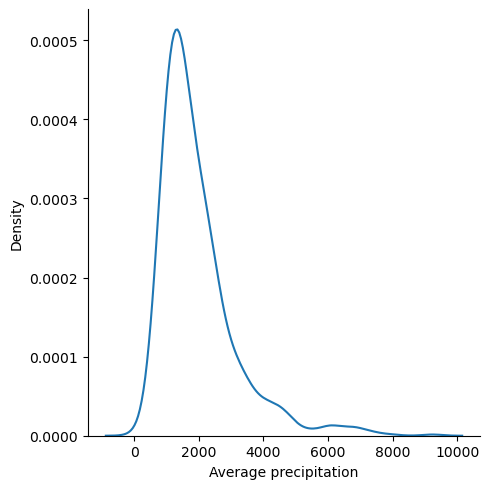

In [18]:
# Geting historic data from municipalitis which there are data before 2000.
ideam_TS_gp_muni_avg_hist = ideam_TS_muni[ideam_TS_muni['year']<2000].\
    groupby(['codmpio', 'year']).agg(avg_ppm_muni_by_year_hist = ('tot_ppm_year', 'mean')).reset_index()

# Geting historic data from municipalitis which there are data before 2000.
ideam_TS_avg_std = ideam_TS_gp_muni_avg_hist[ideam_TS_gp_muni_avg_hist['year']<2000].\
    groupby(['codmpio']).agg(avg_ppm_muni_hist = ('avg_ppm_muni_by_year_hist', 'mean'), sd_ppm_muni_hist = ('avg_ppm_muni_by_year_hist', 'std')).reset_index()

# Sample density on historic average precipitation
sns.displot(data = ideam_TS_avg_std, x = 'avg_ppm_muni_hist', kind = 'kde')
plt.xlabel('Average precipitation')
plt.grid(False)
plt.plot()

del ideam_TS_gp_muni_avg_hist

### Assign treatment dummies and group of treatment

In [ ]:
# Merging master data with historic information
master = master[['codmpio', 'year', 'month', 
                 'total_analyzed', 'total_area_km2','sz_area_km2', 'subhydro_area_in_muni_km2',
                 'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare', 'scrub',
                 'CODIGO_1','CODIGO_2', 'CODIGO_3', 'avg.ppm_year']]

# Measure average precipitation in the municipality
master_fn_avg =  master.\
    groupby(['codmpio', 'year', 'month',
             'total_analyzed', 'total_area_km2',
             'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare','scrub']).\
                agg(avg_ppm_muni = ('avg.ppm_year', 'mean')).\
                reset_index()

# Measure weighted precipitation by subhydrozone in the municipality
master_fn_w = master.\
    groupby(['codmpio', 'year', 'month', 
             'total_analyzed', 'sz_area_km2', 'subhydro_area_in_muni_km2',
             'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare','scrub']).\
                agg(avg_subhydro_zone = ('avg.ppm_year', 'mean')).\
                reset_index()
master_fn_w['avg_ppm_shzone_weighted'] = master_fn_w['avg_subhydro_zone'] * (master_fn_w['subhydro_area_in_muni_km2']/master_fn_w['sz_area_km2']) 
master_fn_w =  master_fn_w.\
    groupby(['codmpio', 'year']).agg(avg_weihted_ppm_muni = ('avg_ppm_shzone_weighted', 'sum')).\
                reset_index()


# Merge both measures
master_fn = master_fn_avg.merge(master_fn_w, on = ['codmpio','year']).\
    merge(ideam_TS_avg_std, on = 'codmpio', how='left')

del master_fn_w, master_fn_avg

# Municipalitie with no historic data.
non_hist_munis = master_fn.loc[master_fn['avg_ppm_muni_hist'].isna(),'codmpio'].unique() 

# Dealing with Municipalities without historic data
muni_near_munis = [] # Empty list to store near muni municipalities.
num_near_munis = [] # Store numer of near municipalities.

# Looping disntace for near municipalities extraction.
for muni in non_hist_munis:

    # Filtering data.
    temp = muni_sp[muni_sp.codmpio == muni]
    # Geo join by nearest.
    temp_geojoin = gpd.sjoin_nearest(temp,muni_sp,max_distance=100)
    temp_geojoin = temp_geojoin[temp_geojoin['codmpio_right']!=muni]

    # Select and store in list format the nearest municipalities.
    muni_near_munis.append(temp_geojoin['codmpio_right'].to_list()) # Store municipalities.
    num_near_munis.append(len(temp_geojoin['codmpio_right'].to_list())) # Store lenght of near municipalities.

    del temp, temp_geojoin

# Creating DataFrame of near municipalities by municipality
non_hist_munis_df = pd.DataFrame({
    'codmpio':non_hist_munis,
    'near_munis':muni_near_munis,
    'num_munis':num_near_munis   
})

# Split columns by each near_codmpio
non_hist_munis_df['near_munis'] = non_hist_munis_df['near_munis'].astype('str') # Tranforming list to string.
non_hist_munis_df[['near_codmpio_1','near_codmpio_2','near_codmpio_3','near_codmpio_4','near_codmpio_5',
                   'near_codmpio_6','near_codmpio_7','near_codmpio_8','near_codmpio_9','near_codmpio_10']] = non_hist_munis_df['near_munis'].str.split(',', expand=True) # Split muni codes
# Loop for clean output
for col in ['near_codmpio_1','near_codmpio_2','near_codmpio_3','near_codmpio_4','near_codmpio_5','near_codmpio_6','near_codmpio_7','near_codmpio_8','near_codmpio_9','near_codmpio_10']:
    non_hist_munis_df[col] = non_hist_munis_df[col].str.extract('(\d+)') # Clean output

# Measure standar deviation of the historic mean precipitation
master_fn['deviation'] = (master_fn['avg_ppm_muni'] - master_fn['avg_ppm_muni_hist']) / master_fn['sd_ppm_muni_hist']
master_fn['deviation_weighted'] = (master_fn['avg_weihted_ppm_muni'] - master_fn['avg_ppm_muni_hist']) / master_fn['sd_ppm_muni_hist']

#############
# Treatment variables for munis with historic information
#############
for sd in [1, 1.5, 2, 2.5]:
    master_fn['treat_' + str(sd) + 'SD'] = np.where(master_fn['deviation'] > sd, 1, 0) # Creating dummy of deviations.
    master_fn['treat_group_' + str(sd) + 'SD'] = np.where(master_fn['treat_' + str(sd) + 'SD'] == 1, master_fn['year'], None) # Extracting year when extream precipitation happened.

# Creating groups where treatment began.    
master_fn_gp = master_fn.groupby('codmpio')[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']].min().reset_index()

# Cols of interest to avoid duplication and renaming columns.
select_cols=['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 
             'trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub',
             'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist',
             'sd_ppm_muni_hist', 'deviation', 'deviation_weighted',
             'treat_1SD','treat_1.5SD', 'treat_2SD', 'treat_2.5SD']
master_fn = master_fn[select_cols].merge(master_fn_gp,on='codmpio')

# Treatment dummies
for sd in [1, 1.5, 2, 2.5]:
    master_fn['treat_dummy_'+str(sd)+'SD'] = np.where(master_fn['treat_group_' + str(sd) + 'SD'] <= master_fn['year'], 1, 0) # Creating dummy of treatment.    

#############
# Treatment variables for munis without historic information
#############
non_hist_munis_treat_df = pd.DataFrame() # Empty dataset to store new variables
i = 0 # iterator setting to 0
import ast # Lib for list information extraction from a string
for muni in non_hist_munis:
    # Filter data for municipality of interest
    temp = master_fn[master_fn['codmpio'].isin(ast.literal_eval(non_hist_munis_df.loc[non_hist_munis_df['codmpio'] == muni , 'near_munis'][i]))]
    temp = temp[['codmpio', 'year','treat_1SD','treat_1.5SD', 'treat_2SD', 'treat_2.5SD']]
    temp = temp[~temp['codmpio'].isin(non_hist_munis_df['codmpio'])]

    # Grouping to extract the meaning
    temp_gp = temp.groupby('year').agg(treat_1SD = ('treat_1SD','mean'), treat_15SD = ('treat_1.5SD','mean'),
                                       treat_2SD = ('treat_2SD','mean'), treat_25SD = ('treat_2.5SD','mean')).\
        reset_index()
    temp_gp.rename(columns = {'treat_15SD':'treat_1.5SD', 'treat_25SD':'treat_2.5SD'}, inplace = True)

    for sd in [1, 1.5, 2, 2.5]:
        temp_gp['treat_' + str(sd) + 'SD'] = np.where(temp_gp['treat_' + str(sd) + 'SD'] >= 0.5, 1,0)
        temp_gp['treat_group_' + str(sd) + 'SD'] = np.where(temp_gp['treat_' + str(sd) + 'SD'] == 1, temp_gp['year'], None) # Extracting year when extream precipitation happened. 

    # Creating groups where treatment began.    
    temp_gp[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']] = temp_gp[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']].min()

    # Treatment dummies
    for sd in [1, 1.5, 2, 2.5]:
        temp_gp['treat_dummy_'+str(sd)+'SD'] = np.where(temp_gp['treat_group_' + str(sd) + 'SD'] <= temp_gp['year'], 1, 0) # Creating dummy of treatment.

    # Adding codmpio
    temp_gp['codmpio'] = muni 
    # Concat to non_hist_munis_treat_df
    non_hist_munis_treat_df = pd.concat([non_hist_munis_treat_df, temp_gp], ignore_index = True)
    
    # Iterator
    i += 1
    
    # CLean environtment
    del temp, temp_gp


# All variables
non_hist_munis_fn = master_fn.loc[master_fn['codmpio'].isin(non_hist_munis),
                                  ['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2',
                                   'trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub',
                                   'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist','sd_ppm_muni_hist',
                                   'deviation', 'deviation_weighted']].merge(non_hist_munis_treat_df, on = ['codmpio', 'year'])


# Getting final dataset
master_fn_fil = master_fn[~ master_fn['codmpio'].isin(non_hist_munis)] # Filtering with munis with historic information
pre_master_final = pd.concat([master_fn_fil,non_hist_munis_fn]) # Add munis without historic information

# Clean environtment
del master_fn_fil, non_hist_munis_fn, non_hist_munis_df, non_hist_munis

# Handle data
pre_master_final = pre_master_final.fillna(0) # Fill NaN to 0 to avoid error saving to STATA format
print('Panel unbalanced:\n',pre_master_final.value_counts('year'))

# Filtering for municipalities that have data in all years in order to have balanced panel.
pre_master_final = pre_master_final[pre_master_final['codmpio'].isin(pre_master_final[(pre_master_final['year']==2022)].codmpio.unique())]
pre_master_final = pre_master_final[pre_master_final['codmpio'].isin(pre_master_final[(pre_master_final['year']==2020)].codmpio.unique())]
print('Panel balanced:\n',pre_master_final.value_counts('year')) 
# Saving data
pre_master_final.to_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw.dta',version = 118, write_index = False)#,variable_labels = labels)

# ============================
# Dry events
# ============================

# Merging master data with historic information
master = master[['codmpio', 'year', 'month', 
                 'total_analyzed', 'total_area_km2','sz_area_km2', 'subhydro_area_in_muni_km2',
                 'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare', 'scrub',
                 'CODIGO_1','CODIGO_2', 'CODIGO_3', 'avg.ppm_year']]

# Measure average precipitation in the municipality
master_fn_avg =  master.\
    groupby(['codmpio', 'year', 'month',
             'total_analyzed', 'total_area_km2',
             'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare','scrub']).\
                agg(avg_ppm_muni = ('avg.ppm_year', 'mean')).\
                reset_index()

# Measure weighted precipitation by subhydrozone in the municipality
master_fn_w = master.\
    groupby(['codmpio', 'year', 'month', 
             'total_analyzed', 'sz_area_km2', 'subhydro_area_in_muni_km2',
             'trees', 'crops', 'grass','water', 'flooded_vegetation', 'built', 'bare','scrub']).\
                agg(avg_subhydro_zone = ('avg.ppm_year', 'mean')).\
                reset_index()
master_fn_w['avg_ppm_shzone_weighted'] = master_fn_w['avg_subhydro_zone'] * (master_fn_w['subhydro_area_in_muni_km2']/master_fn_w['sz_area_km2']) 
master_fn_w =  master_fn_w.\
    groupby(['codmpio', 'year']).agg(avg_weihted_ppm_muni = ('avg_ppm_shzone_weighted', 'sum')).\
                reset_index()


# Merge both measures
master_fn = master_fn_avg.merge(master_fn_w, on = ['codmpio','year']).\
    merge(ideam_TS_avg_std, on = 'codmpio', how='left')

del master_fn_w, master_fn_avg

# Municipalitie with no historic data.
non_hist_munis = master_fn.loc[master_fn['avg_ppm_muni_hist'].isna(),'codmpio'].unique() 

# Dealing with Municipalities without historic data
muni_near_munis = [] # Empty list to store near muni municipalities.
num_near_munis = [] # Store numer of near municipalities.

# Looping disntace for near municipalities extraction.
for muni in non_hist_munis:

    # Filtering data.
    temp = muni_sp[muni_sp.codmpio == muni]
    # Geo join by nearest.
    temp_geojoin = gpd.sjoin_nearest(temp,muni_sp,max_distance=100)
    temp_geojoin = temp_geojoin[temp_geojoin['codmpio_right']!=muni]

    # Select and store in list format the nearest municipalities.
    muni_near_munis.append(temp_geojoin['codmpio_right'].to_list()) # Store municipalities.
    num_near_munis.append(len(temp_geojoin['codmpio_right'].to_list())) # Store lenght of near municipalities.

    del temp, temp_geojoin

# Creating DataFrame of near municipalities by municipality
non_hist_munis_df = pd.DataFrame({
    'codmpio':non_hist_munis,
    'near_munis':muni_near_munis,
    'num_munis':num_near_munis   
})

# Split columns by each near_codmpio
non_hist_munis_df['near_munis'] = non_hist_munis_df['near_munis'].astype('str') # Tranforming list to string.
non_hist_munis_df[['near_codmpio_1','near_codmpio_2','near_codmpio_3','near_codmpio_4','near_codmpio_5',
                   'near_codmpio_6','near_codmpio_7','near_codmpio_8','near_codmpio_9','near_codmpio_10']] = non_hist_munis_df['near_munis'].str.split(',', expand=True) # Split muni codes
# Loop for clean output
for col in ['near_codmpio_1','near_codmpio_2','near_codmpio_3','near_codmpio_4','near_codmpio_5','near_codmpio_6','near_codmpio_7','near_codmpio_8','near_codmpio_9','near_codmpio_10']:
    non_hist_munis_df[col] = non_hist_munis_df[col].str.extract('(\d+)') # Clean output

# Measure standar deviation of the historic mean precipitation
master_fn['deviation'] = ((master_fn['avg_ppm_muni'] - master_fn['avg_ppm_muni_hist']) / master_fn['sd_ppm_muni_hist'])*(-1)
master_fn['deviation_weighted'] = ((master_fn['avg_weihted_ppm_muni'] - master_fn['avg_ppm_muni_hist']) / master_fn['sd_ppm_muni_hist'])*(-1)

#############
# Treatment variables for munis with historic information
#############
for sd in [1, 1.5, 2, 2.5]:
    master_fn['treat_' + str(sd) + 'SD'] = np.where(master_fn['deviation'] > sd, 1, 0) # Creating dummy of deviations.
    master_fn['treat_group_' + str(sd) + 'SD'] = np.where(master_fn['treat_' + str(sd) + 'SD'] == 1, master_fn['year'], None) # Extracting year when extream precipitation happened.

# Creating groups where treatment began.    
master_fn_gp = master_fn.groupby('codmpio')[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']].min().reset_index()

# Cols of interest to avoid duplication and renaming columns.
select_cols=['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 
             'trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub',
             'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist',
             'sd_ppm_muni_hist', 'deviation', 'deviation_weighted',
             'treat_1SD','treat_1.5SD', 'treat_2SD', 'treat_2.5SD']
master_fn = master_fn[select_cols].merge(master_fn_gp,on='codmpio')

# Treatment dummies
for sd in [1, 1.5, 2, 2.5]:
    master_fn['treat_dummy_'+str(sd)+'SD'] = np.where(master_fn['treat_group_' + str(sd) + 'SD'] <= master_fn['year'], 1, 0) # Creating dummy of treatment.    

#############
# Treatment variables for munis without historic information
#############
non_hist_munis_treat_df = pd.DataFrame() # Empty dataset to store new variables
i = 0 # iterator setting to 0
import ast # Lib for list information extraction from a string
for muni in non_hist_munis:
    # Filter data for municipality of interest
    temp = master_fn[master_fn['codmpio'].isin(ast.literal_eval(non_hist_munis_df.loc[non_hist_munis_df['codmpio'] == muni , 'near_munis'][i]))]
    temp = temp[['codmpio', 'year','treat_1SD','treat_1.5SD', 'treat_2SD', 'treat_2.5SD']]
    temp = temp[~temp['codmpio'].isin(non_hist_munis_df['codmpio'])]

    # Grouping to extract the meaning
    temp_gp = temp.groupby('year').agg(treat_1SD = ('treat_1SD','mean'), treat_15SD = ('treat_1.5SD','mean'),
                                       treat_2SD = ('treat_2SD','mean'), treat_25SD = ('treat_2.5SD','mean')).\
        reset_index()
    temp_gp.rename(columns = {'treat_15SD':'treat_1.5SD', 'treat_25SD':'treat_2.5SD'}, inplace = True)

    for sd in [1, 1.5, 2, 2.5]:
        temp_gp['treat_' + str(sd) + 'SD'] = np.where(temp_gp['treat_' + str(sd) + 'SD'] >= 0.5, 1,0)
        temp_gp['treat_group_' + str(sd) + 'SD'] = np.where(temp_gp['treat_' + str(sd) + 'SD'] == 1, temp_gp['year'], None) # Extracting year when extream precipitation happened. 

    # Creating groups where treatment began.    
    temp_gp[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']] = temp_gp[['treat_group_1SD','treat_group_1.5SD','treat_group_2SD','treat_group_2.5SD']].min()

    # Treatment dummies
    for sd in [1, 1.5, 2, 2.5]:
        temp_gp['treat_dummy_'+str(sd)+'SD'] = np.where(temp_gp['treat_group_' + str(sd) + 'SD'] <= temp_gp['year'], 1, 0) # Creating dummy of treatment.

    # Adding codmpio
    temp_gp['codmpio'] = muni 
    # Concat to non_hist_munis_treat_df
    non_hist_munis_treat_df = pd.concat([non_hist_munis_treat_df, temp_gp], ignore_index = True)
    
    # Iterator
    i += 1
    
    # CLean environtment
    del temp, temp_gp


# All variables
non_hist_munis_fn = master_fn.loc[master_fn['codmpio'].isin(non_hist_munis),
                                  ['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2',
                                   'trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub',
                                   'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist','sd_ppm_muni_hist',
                                   'deviation', 'deviation_weighted']].merge(non_hist_munis_treat_df, on = ['codmpio', 'year'])


# Getting final dataset
master_fn_fil = master_fn[~ master_fn['codmpio'].isin(non_hist_munis)] # Filtering with munis with historic information
pre_master_final_dry = pd.concat([master_fn_fil,non_hist_munis_fn]) # Add munis without historic information

# Clean environtment
del master_fn_fil, non_hist_munis_fn, non_hist_munis_df, non_hist_munis

# Handle data
pre_master_final_dry = pre_master_final_dry.fillna(0) # Fill NaN to 0 to avoid error saving to STATA format
print('Panel unbalanced:\n',pre_master_final_dry.value_counts('year'))

# Filtering for municipalities that have data in all years in order to have balanced panel.
pre_master_final_dry = pre_master_final_dry[pre_master_final_dry['codmpio'].isin(pre_master_final_dry[(pre_master_final_dry['year']==2022)].codmpio.unique())]
pre_master_final_dry = pre_master_final_dry[pre_master_final_dry['codmpio'].isin(pre_master_final_dry[(pre_master_final_dry['year']==2020)].codmpio.unique())]
print('Panel balanced:\n',pre_master_final_dry.value_counts('year')) 
# Saving data
pre_master_final_dry.to_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw2.dta',version = 118, write_index = False)#,variable_labels = labels)

Panel unbalanced:
 year
2015    1117
2016    1117
2017    1116
2018    1115
2019    1115
2021    1115
2020    1114
2022    1111
Name: count, dtype: int64
Panel balanced:
 year
2015    1110
2016    1110
2017    1110
2018    1110
2019    1110
2020    1110
2021    1110
2022    1110
Name: count, dtype: int64
(8880, 31)


In [17]:
pre_master_final = pd.read_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw.dta')
pre_master_final_dry = pd.read_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw2.dta')

print(pre_master_final.columns, pre_master_final.shape) 
print(pre_master_final_dry.columns, pre_master_final_dry.shape)

Index(['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 'trees',
       'crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare',
       'scrub', 'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist',
       'sd_ppm_muni_hist', 'deviation', 'deviation_weighted', 'treat_1SD',
       'treat_1_5SD', 'treat_2SD', 'treat_2_5SD', 'treat_group_1SD',
       'treat_group_1_5SD', 'treat_group_2SD', 'treat_group_2_5SD',
       'treat_dummy_1SD', 'treat_dummy_1_5SD', 'treat_dummy_2SD',
       'treat_dummy_2_5SD'],
      dtype='object') (8880, 31)
Index(['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 'trees',
       'crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare',
       'scrub', 'avg_ppm_muni', 'avg_weihted_ppm_muni', 'avg_ppm_muni_hist',
       'sd_ppm_muni_hist', 'deviation', 'deviation_weighted', 'treat_1SD',
       'treat_1_5SD', 'treat_2SD', 'treat_2_5SD', 'treat_group_1SD',
       'treat_group_1_5SD', 'treat_group_2SD', 'treat_gr

In [25]:
pre_master_final = pd.read_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw.dta')
pre_master_final_dry = pd.read_stata(mainpath+'CreatedData/Temporary/dataset_landuse_raw2.dta')

## Dry events
display(pre_master_final_dry[['treat_1_5SD', 'treat_2SD', 'treat_2_5SD', 'treat_group_1SD',
       'treat_group_1_5SD', 'treat_group_2SD', 'treat_group_2_5SD',
       'treat_dummy_1SD', 'treat_dummy_1_5SD', 'treat_dummy_2SD',
       'treat_dummy_2_5SD']].describe())
## Rainy events
display(pre_master_final[['treat_1_5SD', 'treat_2SD', 'treat_2_5SD', 'treat_group_1SD',
       'treat_group_1_5SD', 'treat_group_2SD', 'treat_group_2_5SD',
       'treat_dummy_1SD', 'treat_dummy_1_5SD', 'treat_dummy_2SD',
       'treat_dummy_2_5SD']].describe())

# Join both data frames
pre_master_final = pre_master_final.merge(pre_master_final_dry, 
                                      on = ['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', 'trees',
                                            'crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare',
                                            'scrub', 'avg_ppm_muni'],
                                      how = 'inner', 
                                      suffixes=['','_dry'])
print(pre_master_final.describe())

,treat_1_5SD,treat_2SD,treat_2_5SD,treat_group_1SD,treat_group_1_5SD,treat_group_2SD,treat_group_2_5SD,treat_dummy_1SD,treat_dummy_1_5SD,treat_dummy_2SD,treat_dummy_2_5SD
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,0.068694,0.030068,0.011599,1162.245045,712.034234,323.424324,125.382883,0.521171,0.299324,0.123086,0.046396
std,0.252947,0.170783,0.107079,996.050879,963.706877,740.108811,487.039327,0.499580,0.457988,0.328554,0.210354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,2015.000000,2015.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2022.000000,2022.000000,2022.000000,2022.000000,1.000000,1.000000,1.000000,1.000000


,treat_1_5SD,treat_2SD,treat_2_5SD,treat_group_1SD,treat_group_1_5SD,treat_group_2SD,treat_group_2_5SD,treat_dummy_1SD,treat_dummy_1_5SD,treat_dummy_2SD,treat_dummy_2_5SD
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,0.113288,0.059910,0.032095,1309.397297,840.490991,487.606306,296.614414,0.352365,0.189302,0.103716,0.057095
std,0.316963,0.237333,0.176261,963.746656,995.461760,864.336465,714.987211,0.477734,0.391770,0.304909,0.232036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,2021.000000,2018.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2022.000000,2022.000000,2022.000000,2022.000000,1.000000,1.000000,1.000000,1.000000


            codmpio         year        month  total_analyzed  total_area_km2  \
count   8880.000000  8880.000000  8880.000000     8880.000000     8880.000000   
mean   38580.266667  2018.500000     6.178153      712.997229     1018.957678   
std    26437.001939     2.291417     4.200357     2641.144705     3226.153476   
min     5001.000000  2015.000000     1.000000        0.000000        6.891800   
25%    15676.000000  2016.750000     2.000000       74.184175      128.517800   
50%    25820.000000  2018.500000     7.000000      173.855950      284.290050   
75%    66440.000000  2020.250000    10.000000      439.188150      712.171900   
max    99773.000000  2022.000000    12.000000    64479.847700    65729.656200   

              trees        crops         grass         water  \
count   8880.000000  8880.000000   8880.000000   8880.000000   
mean     496.619638     7.342750    102.540788     15.885418   
std     2085.507837    24.034494    474.483166    189.731115   
min        0.0

### Adding percentages transformation

In [26]:
# Transforming 0 to missing values
pre_master_final['total_analyzed'] = np.where( pre_master_final['total_analyzed'] == 0, np.nan, pre_master_final['total_analyzed'])
for land in ['trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub']:
    pre_master_final[land] = np.where( pre_master_final['total_analyzed'].isna() , np.nan, pre_master_final[land])

print('Number of municipalities with NaN values in area analyzed:', pre_master_final[pre_master_final.total_analyzed.isna()].codmpio.nunique())

# Municipalities with nan condition
nan_munis = pre_master_final[ pre_master_final['total_analyzed'].isna() ].codmpio.unique()

# Filtering data
master_raw = pre_master_final[ ~ pre_master_final['codmpio'].isin(nan_munis) ]
pre_master_nan = pre_master_final[ pre_master_final['codmpio'].isin(nan_munis) ]

# Filling missing values in data with missind area information
for muni in pre_master_nan.codmpio.unique():
    # Filter data by 
    temp = pre_master_nan[pre_master_nan['codmpio'] == muni]
    temp = temp.set_index('year').interpolate(method='linear').reset_index() # Interpolating data to fill missings values.
    temp = temp.fillna(method = 'bfill') # Filling with the next area observation when missing value happens in 2015.
    master_raw = pd.concat( [master_raw,temp], ignore_index = True )
    del temp

master_raw['p_total_analyzed'] = master_raw['total_analyzed'] / master_raw['total_area_km2']
for land in ['trees','crops', 'grass', 'water', 'flooded_vegetation', 'built', 'bare','scrub']:
     master_raw[land+'_3'] = ( master_raw[land] * master_raw['total_area_km2'] / master_raw['total_analyzed'] )
     master_raw['p_'+land] = (master_raw[land+'_3'] / master_raw['total_area_km2'])*100

# Saving data
master_final = master_raw.copy()

# Correcting names.
new_names={'avg_weihted_ppm_muni' : 'avg_weighted_ppm_muni'}
master_final.rename(mapper = new_names, axis = 1, inplace = True)
# Areas sum
master_final['p_total'] = master_final[['p_trees', 'p_crops','p_grass', 'p_water', 'p_flooded_vegetation', 'p_built', 'p_bare','p_scrub']].sum(axis = 1)
master_final = master_final[['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2', # Municipal data 
                            'avg_ppm_muni', 'avg_weighted_ppm_muni', 'avg_ppm_muni_hist','sd_ppm_muni_hist', # Precipitation data
                            'deviation', 'deviation_weighted', # Treatment intensity
                            # Rainy variables
                            'treat_1SD','treat_1_5SD', 'treat_2SD', 'treat_2_5SD', # Dummy first ayipic precipitation
                            'treat_group_1SD','treat_group_1_5SD', 'treat_group_2SD', 'treat_group_2_5SD', # Treatment group identification
                            'treat_dummy_1SD', 'treat_dummy_1_5SD', 'treat_dummy_2SD','treat_dummy_2_5SD', # Dummies that identify behaivor change
                            # Dry variables
                            'treat_1SD_dry', 'treat_1_5SD_dry','treat_2SD_dry', 'treat_2_5SD_dry',
                            'treat_group_1SD_dry', 'treat_group_1_5SD_dry', 'treat_group_2SD_dry', 'treat_group_2_5SD_dry',
                            'treat_dummy_1SD_dry', 'treat_dummy_1_5SD_dry', 'treat_dummy_2SD_dry','treat_dummy_2_5SD_dry',
                            # Land use portion variables
                            'p_total_analyzed', 'p_trees', 'p_crops', 'p_grass', 'p_water', 'p_flooded_vegetation', 'p_built', 'p_bare', 'p_scrub', 'p_total']]

# Saving data
master_final.to_stata(mainpath+'CreatedData/Temporary/dataset_landuse_v_py_nocovariates.dta',version = 118, write_index = False)
print(master_final.shape)

del master_raw, pre_master_nan, pre_master_final

Number of municipalities with NaN values in area analyzed: 176
(8880, 45)


In [27]:
print(master_final.columns)

Index(['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2',
       'avg_ppm_muni', 'avg_weighted_ppm_muni', 'avg_ppm_muni_hist',
       'sd_ppm_muni_hist', 'deviation', 'deviation_weighted', 'treat_1SD',
       'treat_1_5SD', 'treat_2SD', 'treat_2_5SD', 'treat_group_1SD',
       'treat_group_1_5SD', 'treat_group_2SD', 'treat_group_2_5SD',
       'treat_dummy_1SD', 'treat_dummy_1_5SD', 'treat_dummy_2SD',
       'treat_dummy_2_5SD', 'treat_1SD_dry', 'treat_1_5SD_dry',
       'treat_2SD_dry', 'treat_2_5SD_dry', 'treat_group_1SD_dry',
       'treat_group_1_5SD_dry', 'treat_group_2SD_dry', 'treat_group_2_5SD_dry',
       'treat_dummy_1SD_dry', 'treat_dummy_1_5SD_dry', 'treat_dummy_2SD_dry',
       'treat_dummy_2_5SD_dry', 'p_total_analyzed', 'p_trees', 'p_crops',
       'p_grass', 'p_water', 'p_flooded_vegetation', 'p_built', 'p_bare',
       'p_scrub', 'p_total'],
      dtype='object')


In [22]:
master_final[['p_trees', 'p_crops','p_grass', 'p_water', 'p_flooded_vegetation', 'p_built', 'p_bare', 'p_scrub', 'p_total']].describe()

,p_trees,p_crops,p_grass,p_water,p_flooded_vegetation,p_built,p_bare,p_scrub,p_total
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,61.000379,3.696781,16.697516,2.050166,0.513891,1.520069,0.640611,13.371143,99.490558
std,24.512218,9.237891,14.230340,6.401195,2.479319,2.914987,2.183780,15.937369,3.502960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.688799,0.098955,5.833434,0.070140,0.000000,0.270282,0.032676,2.325050,99.784779
50%,65.386352,0.447550,12.876745,0.391045,0.001508,0.633282,0.128054,6.423918,99.969141
75%,81.276622,2.166555,24.203121,1.296367,0.054871,1.503706,0.434888,18.709075,99.999536
max,99.985996,87.528143,100.000000,100.000000,59.652870,54.668142,48.242296,98.175081,100.066756


In [28]:
master_final.value_counts('year')

year
2015    1110
2016    1110
2017    1110
2018    1110
2019    1110
2020    1110
2021    1110
2022    1110
Name: count, dtype: int64